In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.tensorboard import SummaryWriter
import datetime
import numpy as np
import subs.QUEST as qu
import sub.sub_plot as spl
import sub.analysis as an
import matplotlib.pyplot as plt

In [2]:
# tensorboardのログ用
dir_name='default'

In [3]:
# TensorBoard用の設定
log_dir = f"modellogs/{dir_name}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [4]:
col_in = ['PF17kA','PF26kA', 'PlasmaCurrentkA']
col_out= ['bz_val_ozm400','bz_val_oz000','bz_val_ozp400','bz_val_czp800','bz_val_czp400','bz_val_cz000','bz_val_czm400','bz_val_czm800']

In [5]:
exp_val = pd.read_csv('27207.txt')
#exp_val = exp_val[exp_val['time']>=0.0]


In [6]:
data = 'r07'
equi = pd.read_csv(data+'.txt').dropna(how='any')

In [7]:
r_time = exp_val.pop('time')
#df = equi.drop('Unnamed: 0', axis = 1)
X = exp_val[col_in]*1e+3
y = equi[col_out]

In [8]:
X_stats = X.describe().transpose()
y_stats = y.describe().transpose()

In [9]:
# データの正規化 - dataframeのまま
normed_X = (X - X_stats['mean']) / X_stats['std']
normed_y = (y - y_stats['mean']) / y_stats['std']

In [10]:
class EqModel(torch.nn.Module):

  def __init__(self):
    super(EqModel, self).__init__()
    self.fc1 = torch.nn.Linear(len(col_in), 64)
    self.fc2 = torch.nn.Linear(64, 64)
    self.fc3 = torch.nn.Linear(64, 64)
    self.fc4 = torch.nn.Linear(64, len(col_out))

  def forward(self, x):
    x = torch.nn.functional.relu(self.fc1(x))
    x = torch.nn.functional.relu(self.fc2(x))
    x = torch.nn.functional.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [11]:
# prepare model and training parameters
model = EqModel()

In [12]:
model.load_state_dict(torch.load('modelexp2'+data+'.pt'))

<All keys matched successfully>

In [13]:
# 予測
model.eval # 評価モードに変更
ts = model(torch.Tensor(normed_X.values)) # tensorでの出力
pred = ts.data.numpy() # numpy配列に変換

In [14]:
# 非正規化で表示
pred_df = pd.DataFrame(pred, columns=col_out)
pred_stats = pred_df.describe().transpose()
# 正規化した値を元に戻す関数
def norm_y_inv(e):
  return e * y_stats['std'] + y_stats['mean']
exppred = norm_y_inv(pred_df)

In [16]:
exppred = pd.concat([r_time, exppred], axis = 1)

In [19]:
dec = qu.readDecDaq01(27207, 1000)
size = dec[0].size

center = 1.3e-3 #V/G
outer = 9e-3

time = dec[0][0:size-1]
ch4 = (dec[1][4][1:size]-np.mean(dec[1][4][size-1000:size]))/outer #ozm400
ch7 = (dec[1][7][1:size]-np.mean(dec[1][7][size-1000:size]))/outer #oz000
ch10 = (dec[1][10][1:size]-np.mean(dec[1][10][size-1000:size]))/outer #ozp400
ch16 = (dec[1][16][1:size]-np.mean(dec[1][16][size-1000:size]))/center #czp800
ch17 = (dec[1][17][1:size]-np.mean(dec[1][17][size-1000:size]))/center #czp400
ch18 = (dec[1][18][1:size]-np.mean(dec[1][18][size-1000:size]))/center #cz000
ch19 = -(dec[1][19][1:size]-np.mean(dec[1][19][size-1000:size]))/center #czm400
ch20 = -(dec[1][20][1:size]-np.mean(dec[1][20][size-1000:size]))/center #czm800

In [20]:

dec = pd.DataFrame((time, ch4, ch7, ch10, ch16, ch17, ch18, ch19, ch20)).T
dec.columns = ['time','bz_val_ozm400','bz_val_oz000','bz_val_ozp400','bz_val_czp800','bz_val_czp400','bz_val_cz000','bz_val_czm400','bz_val_czm800']

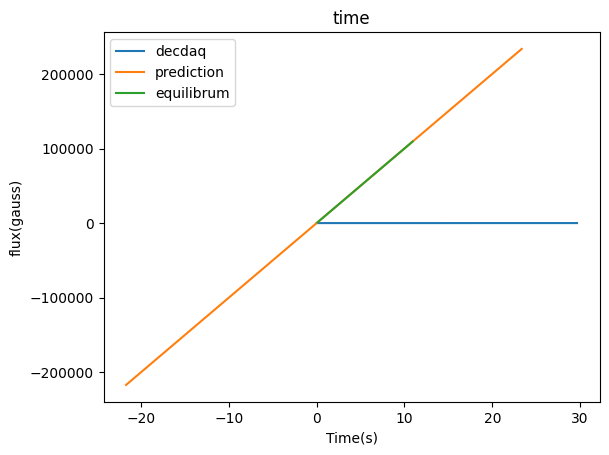

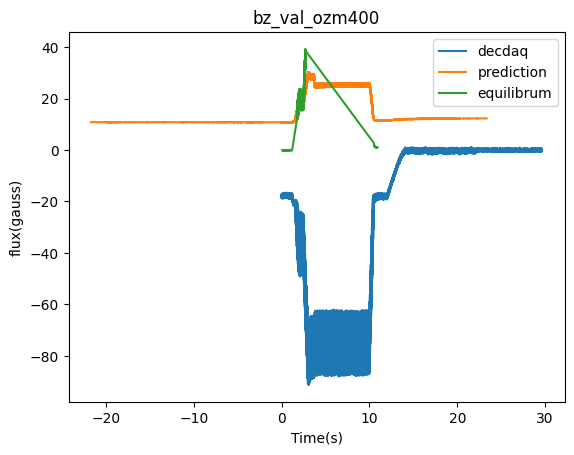

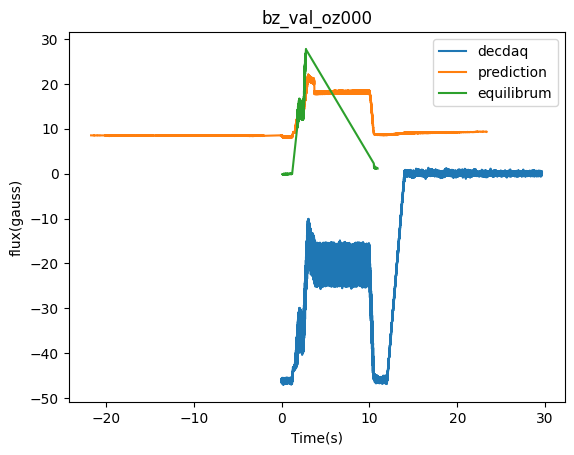

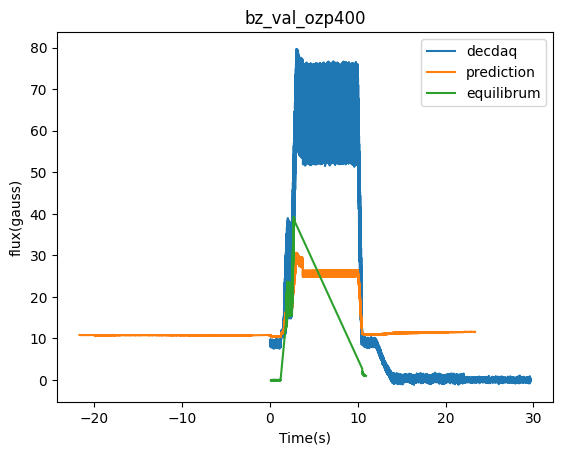

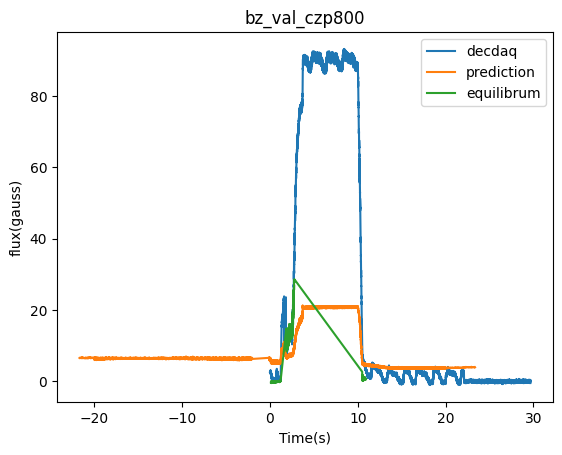

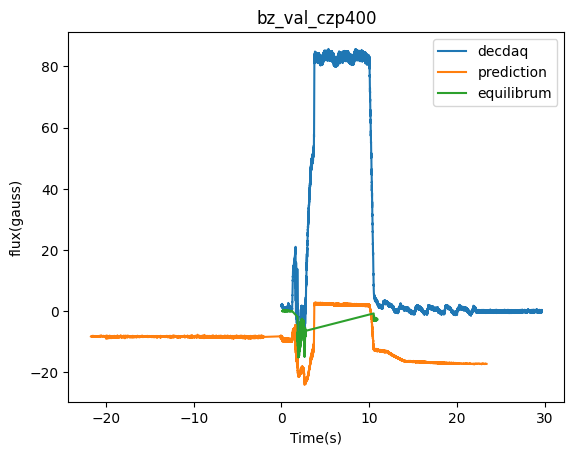

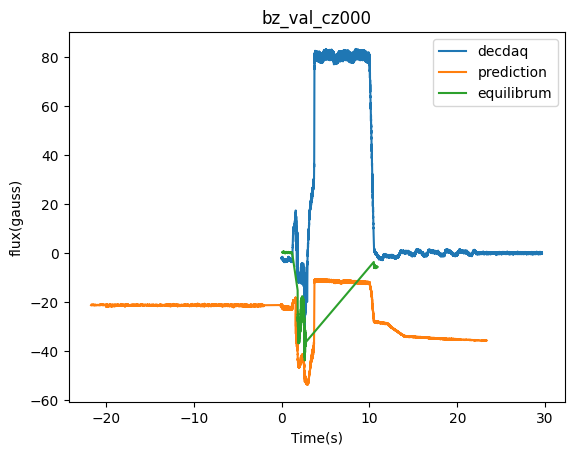

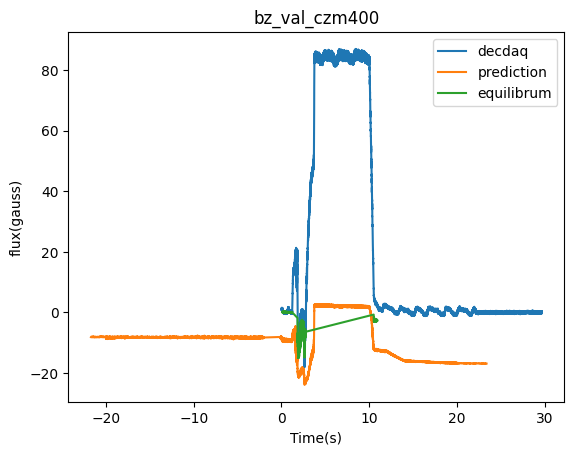

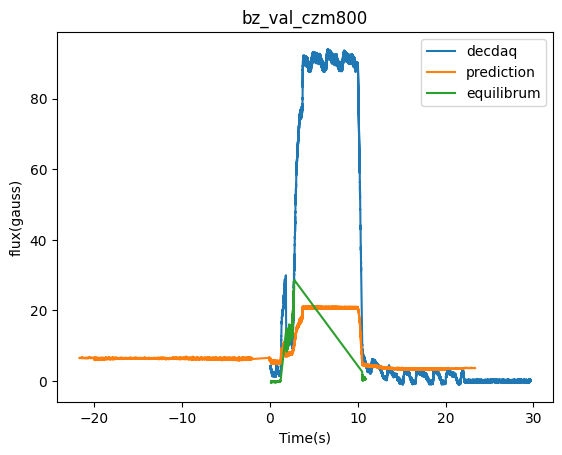

In [21]:
plt = spl.plot_figures(dec, exppred, equi)

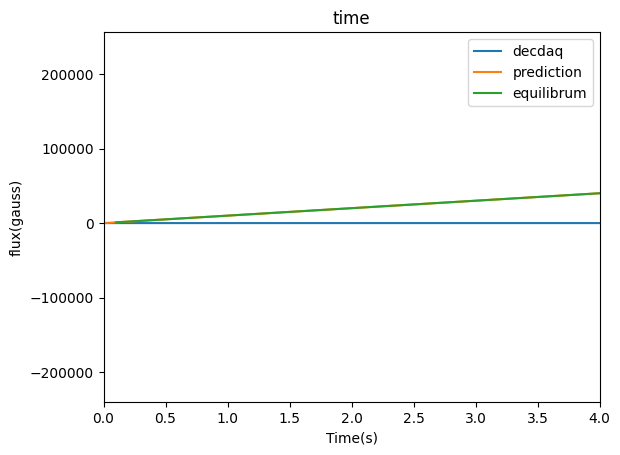

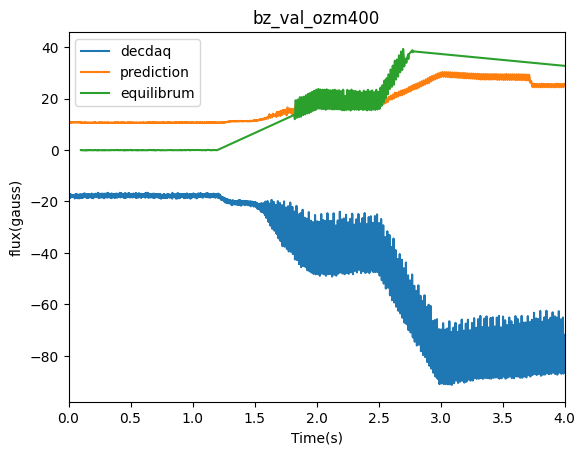

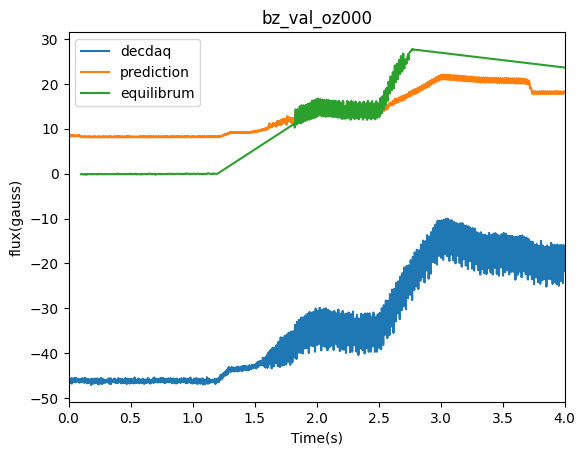

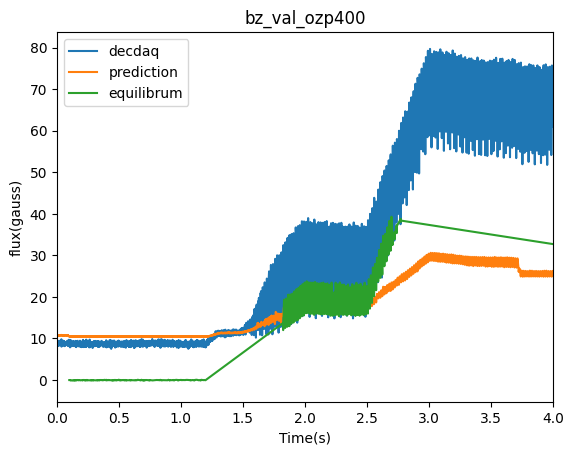

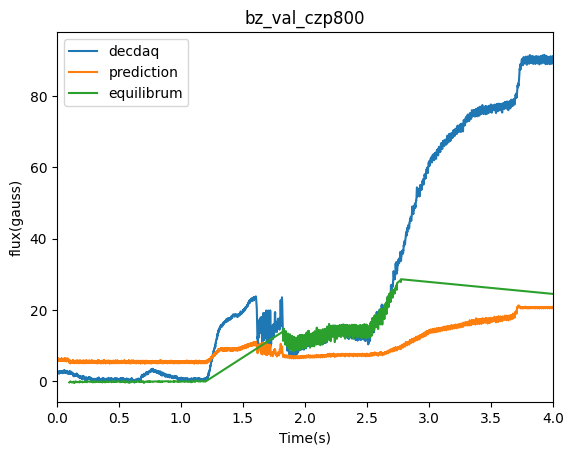

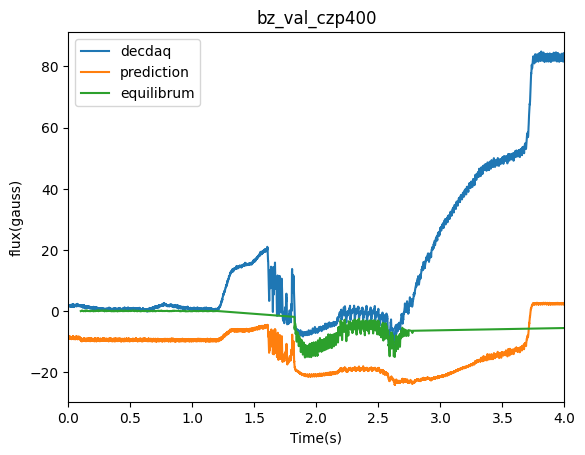

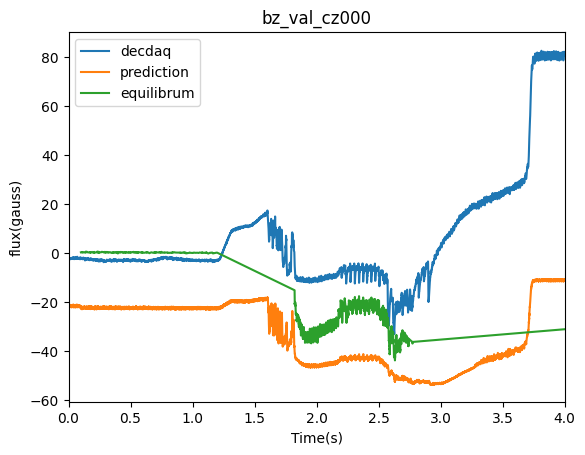

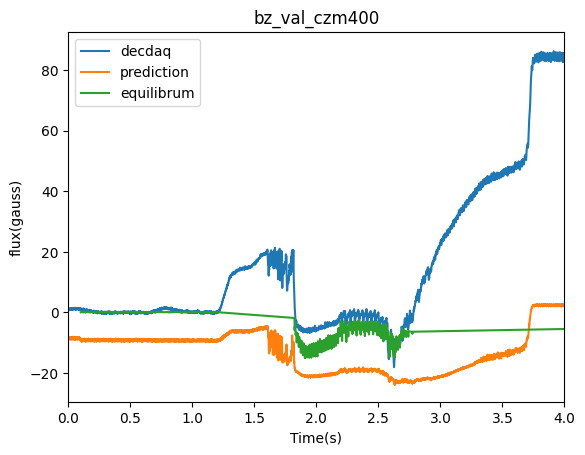

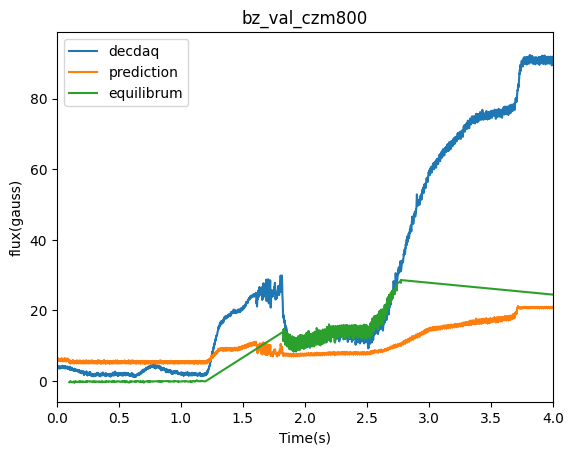

In [22]:
plt = spl.plot_figureslim(dec, exppred, equi)